## 2024.04
### タスク
- 有効な正則化手法の考案
- ランダムパターンでHを再構成

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import localConfig
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [70]:
H_tensor = np.load(localConfig.DATA_PATH + '/systemMatrix/H_matrix_tensor.npy')
H_tensor = H_tensor[:, :, :, 31]
H_tensor[H_tensor <= 1e-3] = 0

nonzero_indices = np.nonzero(H_tensor)
X_sr = np.column_stack(nonzero_indices) # 事例
t_sr = H_tensor[nonzero_indices]

## PCA

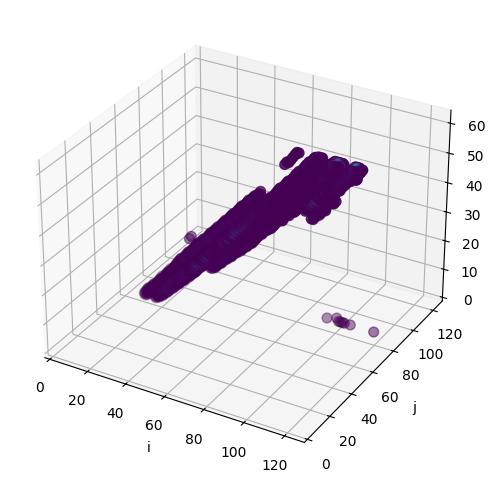

In [71]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, -60)
ax.scatter(X_sr.T[0], X_sr.T[1], X_sr.T[2], c=t_sr, s=50)
ax.set_xlabel('i')
ax.set_ylabel('j')
ax.set_zlabel('l')
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
ax.set_zlim(0, 63)
plt.show()

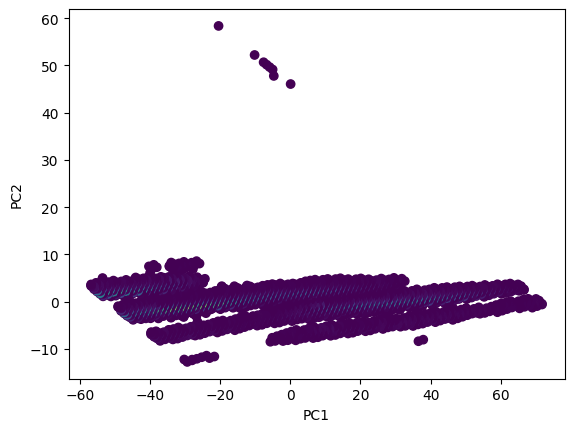

In [72]:
pca = PCA(n_components=3)
pca.fit(X_sr)
images_map = pca.transform(X_sr)

fig = plt.figure()
plt.scatter(images_map.T[0], images_map.T[1], c=t_sr)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [73]:
explained_variance_ratio = pca.explained_variance_ratio_
print("主成分の寄与率:", explained_variance_ratio)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("累積寄与率:", cumulative_variance_ratio)
principal_components = pca.components_
print("主成分の値:")
print(principal_components)

主成分の寄与率: [0.98118258 0.01568218 0.00313524]
累積寄与率: [0.98118258 0.99686476 1.        ]
主成分の値:
[[-0.8555365   0.01163788 -0.51761169]
 [ 0.51279382  0.15694342 -0.84404458]
 [-0.07141286  0.98753902  0.14023866]]


In [74]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# 法線ベクトルの計算
normal_vector = np.cross(pc1, pc2)

# 平面上の点の選択
mean_scores = np.mean(images_map, axis=0)
point_on_plane = pca.inverse_transform(mean_scores)

# 回帰平面の方程式
# ax + by + cz + d = 0
a, b, c = normal_vector
d = -np.dot(normal_vector, point_on_plane)

print("回帰平面の方程式:")
print(f"{a}x + {b}y + {c}z + {d} = 0")

回帰平面の方程式:
0.0714128550899974x + -0.9875390235667998y + -0.14023865751149941z + 62.97257541973595 = 0


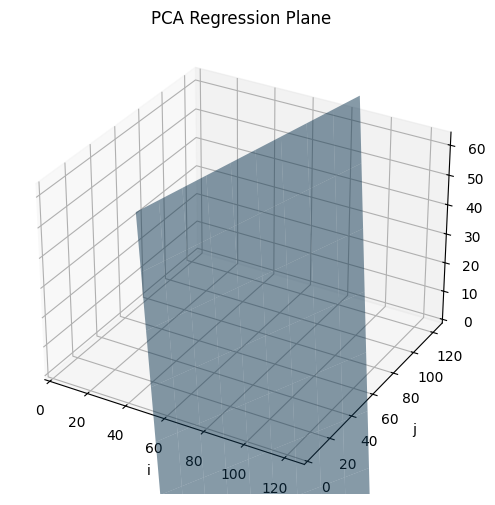

In [75]:
# 回帰平面のプロット用データの生成
x_min, x_max = np.min(X_sr[:, 0]), np.max(X_sr[:, 0])
y_min, y_max = np.min(X_sr[:, 1]), np.max(X_sr[:, 1])
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
zz = (-a * xx - b * yy - d) / c

# プロットの作成
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 回帰平面のプロット
ax.plot_surface(xx, yy, zz, alpha=0.5)

# ラベルの設定
ax.set_xlabel('i')
ax.set_ylabel('j')
ax.set_zlabel('l')
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
ax.set_zlim(0, 63)

# タイトルの設定
ax.set_title('PCA Regression Plane')

plt.show()

## グラフ埋め込み

In [21]:
from sklearn.manifold import SpectralEmbedding
from scipy.spatial.distance import pdist, squareform

# Calculate the distances between all pairs of node
distance_matrix = squareform(pdist(X_sr))

# Find the 5 nearest node
# omit the nearest node since it is itself
NUM_NEAREST = 3
nearest_indices = np.argsort(distance_matrix, axis=1)[:, 1:1 + NUM_NEAREST]

# Create adjacency matrix
adjacency_matrix = np.zeros(distance_matrix.shape)
for i, nearest_nodes in enumerate(nearest_indices):
    for node in nearest_nodes:
        adjacency_matrix[i, node] = 1
        adjacency_matrix[node, i] = 1  # symmetric matrix


se = SpectralEmbedding(n_components=2, affinity="precomputed", random_state=42)
X_sr_transformed = se.fit_transform(adjacency_matrix)

c:\Users\ohara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


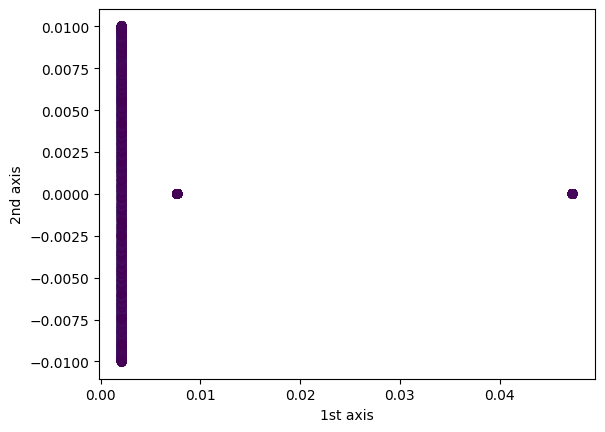

In [22]:
plt.scatter(X_sr_transformed[:,0], X_sr_transformed[:,1], c=t_sr)
plt.xlabel("1st axis")
plt.ylabel("2nd axis")
plt.show()
